# MAFAULDA DATASET

Available in: http://www02.smt.ufrj.br/~offshore/mfs/page_01.html

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy import fftpack, signal 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import cv2
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

Each sequence was generated at a 50 kHz sampling rate during 5 s, totaling 250.000 samples. Below its a summary of each type of sequence

<center><img src="Data_distribution.png" width=1000 height=800/></center>

**Normal Sequences**

There are 49 sequences without any fault, each with a fixed rotation speed within the range from 737 rpm to 3686 rpm with steps of approximately 60 rpm.

<hr>

**Imbalance Faults**

Simulated with load values within the range from 6 g to 35 g. For each load value below 30 g, the rotation frequency assumed in the same 49 values employed in the normal operation case. For loads equal to or above 30 g, however, the resulting vibration makes impracticable for the system to achieve rotation frequencies above 3300 rpm, limiting the number of distinct rotation frequencies. The table below presents the number of sequences per weight.

<hr>

**Horizontal Parallel Misalignment**

This type of fault was induced into the MFS by shifting the motor shaft horizontally of 0.5 mm, 1.0 mm, 1.5 mm, and 2.0 mm. Using the same range for the rotation frequency as in the normal operation for each horizontal shift, the table below presents the number of sequences per degree of misalignment.

<hr>

**Vertical Parallel Misalignment**

This type of fault was induced into the MFS by shifting the motor shaft horizontally of 0.51 mm, 0.63 mm, 1.27 mm, 1.40 mm, 17.8 mm and 1.90 mm. Using the same range for the rotation frequency as in the normal operation for each vertical shift, the table below presents the number of sequences per degree of misalignment.

<hr>

**Bearing Faults**

As one of the most complex elements of the machine, the rolling bearings are the most susceptible elements to fault occurrence. The ABVT manufacturer provided three defective bearing, each one with a distinct defective element (outer track, rolling elements, and inner track), that were placed one at a time in two different positions in the MFS experimental stand: between the rotor and the motor (underhang position), or in the external position, having the rotor between the bearing and the motor (overhang position). Bearing faults are practically imperceptible when there is no imbalance. So, three masses of 6 g, 20 g, and 35 g were added to induce a detectable effect, with different rotation frequencies as before.



## Functions

In [2]:
def get_data(path=""):
    data_ls = os.listdir(path)
    data_set = []
    for data in range(len(data_ls)):
        try:
            ds = pd.read_csv(path + "/" + data_ls[data], header=None)
            ds = ds.rename(columns={0: 'Tachometer', 1: 'UA axial', 2: 'UA radial', 3: 'UA tangential', 4: 'OA axial', 5: 'OA radial', 6: 'OA tangential', 7: 'Microphone'})
            data_set.append(ds)
        except:
            pass
    return data_set


def get_means(data_set):
    means = []
    for i in range(len(data_set)):
        mean = data_set[i].mean(axis = 0)
        means.append(mean)
    
    means = pd.DataFrame(means)
    return means

def get_stds(data_set):
    stds = []
    for i in range(len(data_set)):
        std = data_set[i].std(axis = 0)
        stds.append(std)
    
    stds = pd.DataFrame(stds)    
    return stds


def plot_all_features(data_set):
    plt.figure(figsize=(20, 15))

    #Tachometer works with ttl signal
    plt.subplot(4, 2, 1)
    plt.plot(data_set["Tachometer"], color="blue")
    plt.title("Tachometer graph")
    plt.ylabel('V')

    #All acelerometers works with 10.2 mV/(m/s²) sensitivity 
    plt.subplot(4, 2, 2)
    plt.plot(data_set["UA axial"], color='green')
    plt.title("Underhang axial graph")
    plt.ylabel('mV')

    plt.subplot(4, 2, 3)
    plt.plot(data_set["UA radial"], color="black")
    plt.title("Underhang radial graph")
    plt.ylabel('mV')

    plt.subplot(4, 2, 4)
    plt.plot(data_set["UA tangential"], color='orange')
    plt.title("Underhang tangential graph")
    plt.ylabel('mV')

    plt.subplot(4, 2, 5)
    plt.plot(data_set["OA axial"], color="pink")
    plt.title("Overhang axial graph")
    plt.ylabel('mV')

    plt.subplot(4, 2, 6)
    plt.plot(data_set["OA radial"], color='yellow')
    plt.title("Overhang radial graph")
    plt.ylabel('mV')

    plt.subplot(4, 2, 7)
    plt.plot(data_set["OA tangential"], color="brown")
    plt.title("Overhang tangential graph")
    plt.xlabel('experiments')
    plt.ylabel('mV')

    #Microphone works with dB
    plt.subplot(4, 2, 8)
    plt.plot(data_set["Microphone"], color='gray')
    plt.title("Microphone graph")
    plt.xlabel('experiments')
    plt.ylabel('DB')


def down_sampler(data_set, initial_sample, sample_interval):
    first_sample = initial_sample
    final_sample = sample_interval
    data_decreased = []
    
    for i in range(len(data_set)):
        first_sample = initial_sample
        final_sample = sample_interval
        
        for j in range(int(len(data_set[0])/sample_interval)):
            data = data_set[i][first_sample:final_sample].mean()
            data_decreased.append(data)
        
            first_sample = first_sample + sample_interval
            final_sample = final_sample + sample_interval
            
    data_decreased = pd.DataFrame(data_decreased)  
    return data_decreased

#numpy also has fft but scipy is most efficient
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html
def FFT(data_set):
    autocorr = signal.fftconvolve(data_set, data_set[::-1], mode='full')
    autocorr = pd.DataFrame(autocorr)
    return autocorr

## Data Visualization

### Normal data

Testing to find the relationship between rpm and output tachometer.



In [3]:
normal_data = get_data("data/normal")

In [4]:
print("Normal data set len: ", len(normal_data))
print("Samples: ", len(normal_data[0]))

Normal data set len:  49
Samples:  250000


In [5]:
normal_data[0]

,Tachometer,UA axial,UA radial,UA tangential,OA axial,OA radial,OA tangential,Microphone
0,-0.50610,0.36072,-0.248070,-0.104220,0.88100,-0.007638,0.42106,0.307440
1,-0.56835,-2.09530,-0.344020,-0.166420,0.80345,-0.003762,0.28792,0.094165
2,-0.55387,1.02450,0.156700,-0.094292,1.00410,-0.006361,0.48337,0.018766
3,-0.40905,-2.36720,-0.665870,-0.219600,0.80184,-0.006072,0.24320,0.395320
4,-0.53549,0.75153,0.402890,-0.085917,1.06740,-0.007817,0.45919,-0.219650
...,...,...,...,...,...,...,...,...
249995,-0.32606,1.16000,-0.064636,0.226190,-1.12970,-0.058702,-1.55150,0.097134
249996,-0.60274,-1.19690,-0.280920,0.116160,-1.23570,-0.057874,-1.72690,0.060043
249997,-0.33790,1.15790,0.157300,0.157860,-1.10310,-0.056006,-1.64900,-0.075835
249998,-0.45577,-1.16290,-0.460140,0.014280,-1.25060,-0.058054,-1.78200,0.312130


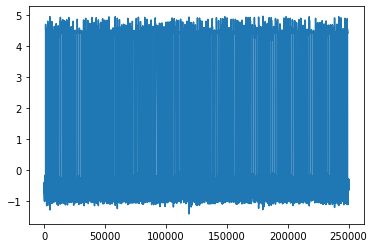

In [11]:
plt.plot(normal_data[0]["Tachometer"])
plt.show()

In [12]:
normal_data[0].describe()

,Tachometer,UA axial,UA radial,UA tangential,OA axial,OA radial,OA tangential,Microphone
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-0.001215,-0.001375,-0.000792,0.000260,0.044000,0.002951,0.090457,0.012599
std,1.693852,0.967021,0.366521,0.111420,0.716696,0.028489,0.582980,0.162769
min,-1.419000,-3.813500,-1.915700,-0.570810,-2.548100,-0.072769,-1.782000,-0.357620
25%,-0.675340,-0.747725,-0.262470,-0.075127,-0.482500,-0.020113,-0.388590,-0.123490
50%,-0.638530,0.131715,0.020698,-0.001854,0.084559,0.003933,0.114295,-0.006813
75%,-0.546870,0.830802,0.278603,0.073649,0.565922,0.026510,0.557040,0.128290
max,4.967900,2.092500,1.435100,0.532590,2.844900,0.072979,1.821800,0.733550


In [13]:
means = get_means(normal_data)
tachometer_means = means["Tachometer"]

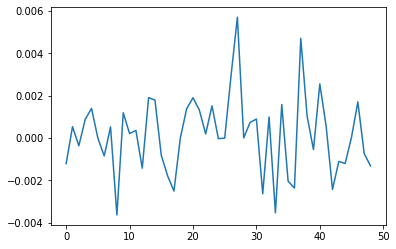

In [14]:
plt.plot(tachometer_means)
plt.show()

<hr>

**The Tachometer output signal is TTL, then this is no useful. But is guaranteed the speed increase**

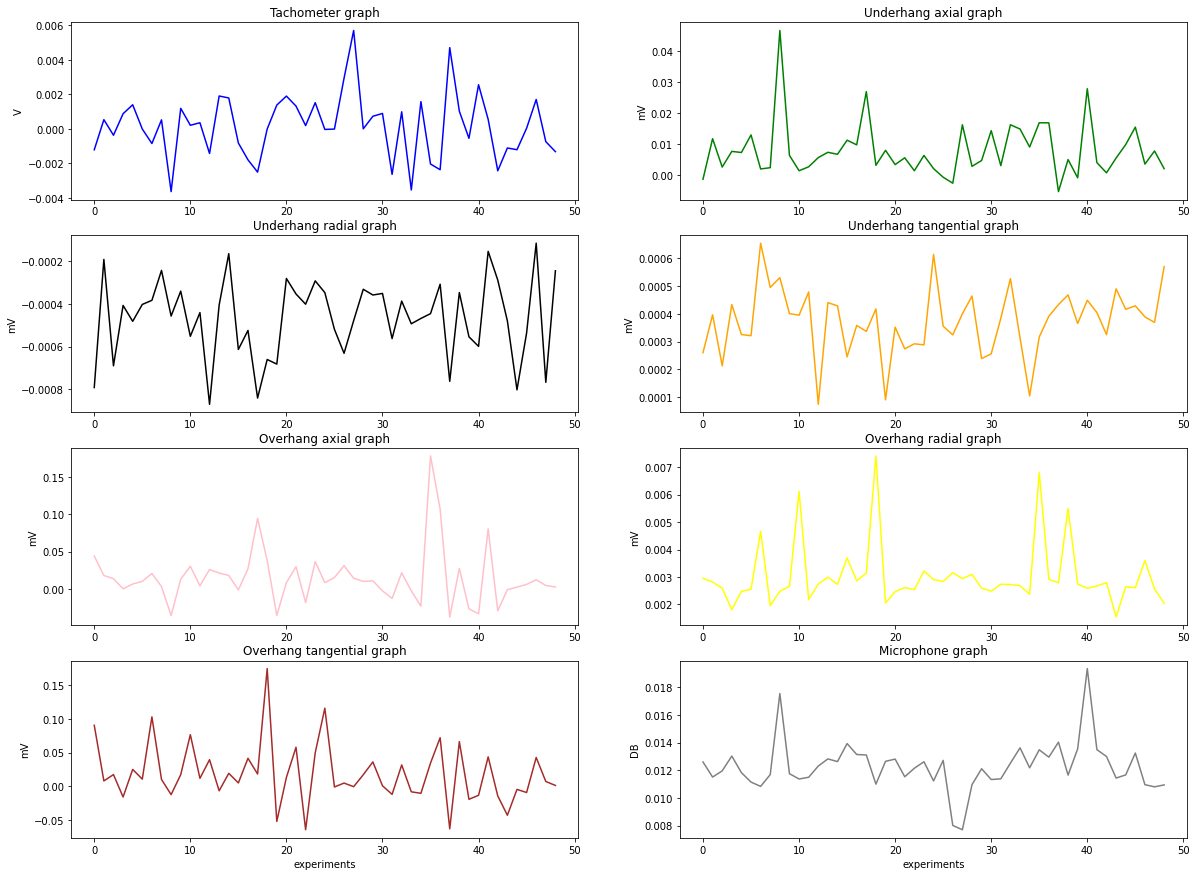

In [15]:
plot_all_features(means)

In [16]:
stds = get_stds(normal_data)

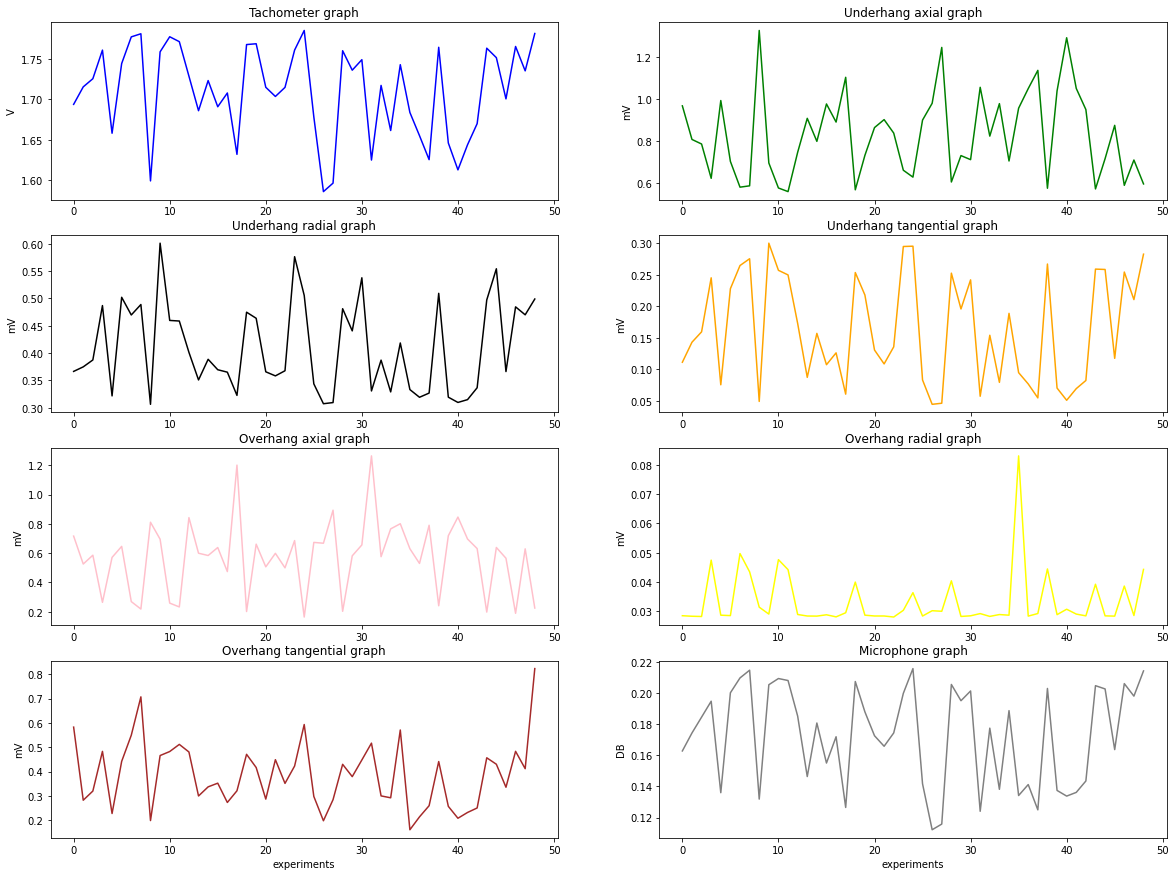

In [17]:
plot_all_features(stds)

In [18]:
normal_reduced = down_sampler(normal_data, 0, 5000)
normal_reduced

,Tachometer,UA axial,UA radial,UA tangential,OA axial,OA radial,OA tangential,Microphone
0,0.027298,0.007382,0.009080,0.001914,1.018441,0.011403,0.627217,0.012846
1,-0.048249,0.003625,-0.010702,0.001602,0.792528,0.000956,0.662295,0.012945
2,-0.127931,-0.016160,-0.003521,0.000138,-0.186234,-0.003084,0.074771,0.013773
3,0.023176,-0.036451,-0.009658,-0.001727,-0.992680,-0.007719,-0.594421,0.014016
4,0.015108,-0.018469,-0.000929,-0.002466,-0.051451,0.009010,-0.292022,0.013743
...,...,...,...,...,...,...,...,...
2445,0.009278,-0.008552,-0.006195,0.000254,-0.234519,-0.037856,-0.316752,0.011099
2446,0.005387,0.011130,-0.002798,0.004146,-0.241987,-0.038936,-0.854980,0.009932
2447,-0.005269,0.004429,0.004445,0.000918,-0.032008,0.000184,-0.726249,0.011563
2448,-0.071088,0.006857,0.002460,0.001321,0.135396,0.026246,-0.339609,0.011905


In [19]:
normal_reduced.shape

(2450, 8)

In [20]:
normal_reduced["Tachometer"]

0       0.027298
1      -0.048249
2      -0.127931
3       0.023176
4       0.015108
          ...   
2445    0.009278
2446    0.005387
2447   -0.005269
2448   -0.071088
2449   -0.035999
Name: Tachometer, Length: 2450, dtype: float64

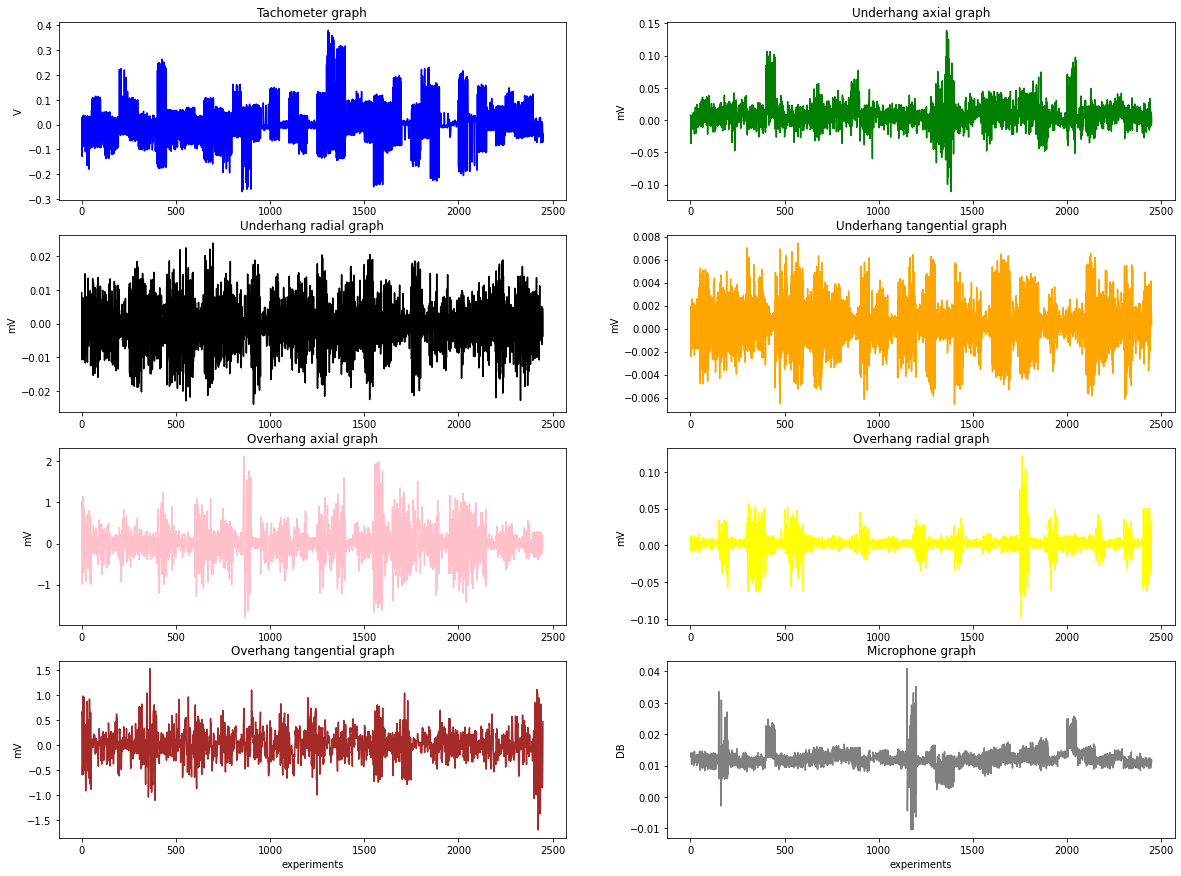

In [21]:
plot_all_features(normal_reduced)

### Imbalance Data

In [22]:
files = os.listdir("data/imbalance/35g")
len(files)

45

In [23]:
imbalance_6 = get_data("data/imbalance/6g")
imbalance_10 = get_data("data/imbalance/10g")
imbalance_15 = get_data("data/imbalance/15g")
imbalance_20 = get_data("data/imbalance/20g")
imbalance_25 = get_data("data/imbalance/25g")
imbalance_30 = get_data("data/imbalance/30g")
imbalance_35 = get_data("data/imbalance/35g")

In [24]:
imbalance_6_reduced = down_sampler(imbalance_6, 0, 5000)
imbalance_10_reduced = down_sampler(imbalance_10, 0, 5000) 
imbalance_15_reduced = down_sampler(imbalance_15, 0, 5000) 
imbalance_20_reduced = down_sampler(imbalance_20, 0, 5000) 
imbalance_25_reduced = down_sampler(imbalance_25, 0, 5000) 
imbalance_30_reduced = down_sampler(imbalance_30, 0, 5000) 
imbalance_35_reduced = down_sampler(imbalance_35, 0, 5000)

In [25]:
imbalance_list = [imbalance_6_reduced,imbalance_10_reduced, imbalance_15_reduced, imbalance_20_reduced, imbalance_25_reduced, imbalance_30_reduced, imbalance_35_reduced]
for i in range (len(imbalance_list)):
    print(imbalance_list[i].shape)

(2450, 8)
(2400, 8)
(2400, 8)
(2450, 8)
(2350, 8)
(2350, 8)
(2250, 8)


In [26]:
imbalance_6_reduced

,Tachometer,UA axial,UA radial,UA tangential,OA axial,OA radial,OA tangential,Microphone
0,0.025625,-0.016291,-0.024663,0.000693,0.066892,0.007786,0.472565,0.013544
1,0.016708,-0.007822,-0.010031,-0.001486,-0.047902,-0.008358,-0.195504,0.013567
2,0.023838,-0.004858,-0.008811,-0.002558,-0.151562,-0.028483,-1.702152,0.014955
3,0.010996,-0.003468,0.007413,-0.002502,0.083624,0.018692,-0.621651,0.012704
4,0.025350,-0.005550,0.014522,-0.000250,0.086814,0.016411,0.310231,0.010840
...,...,...,...,...,...,...,...,...
2445,-0.025310,0.007008,0.036587,0.006325,-0.011116,-0.001842,0.246099,0.011285
2446,-0.033733,-0.010944,-0.008866,0.005737,-0.049097,-0.005640,-0.578739,0.014488
2447,0.049465,0.005268,-0.023376,-0.007103,0.084186,0.017410,0.446636,0.013645
2448,0.018883,0.015853,0.035392,0.005241,0.011312,0.005432,0.590640,0.011213


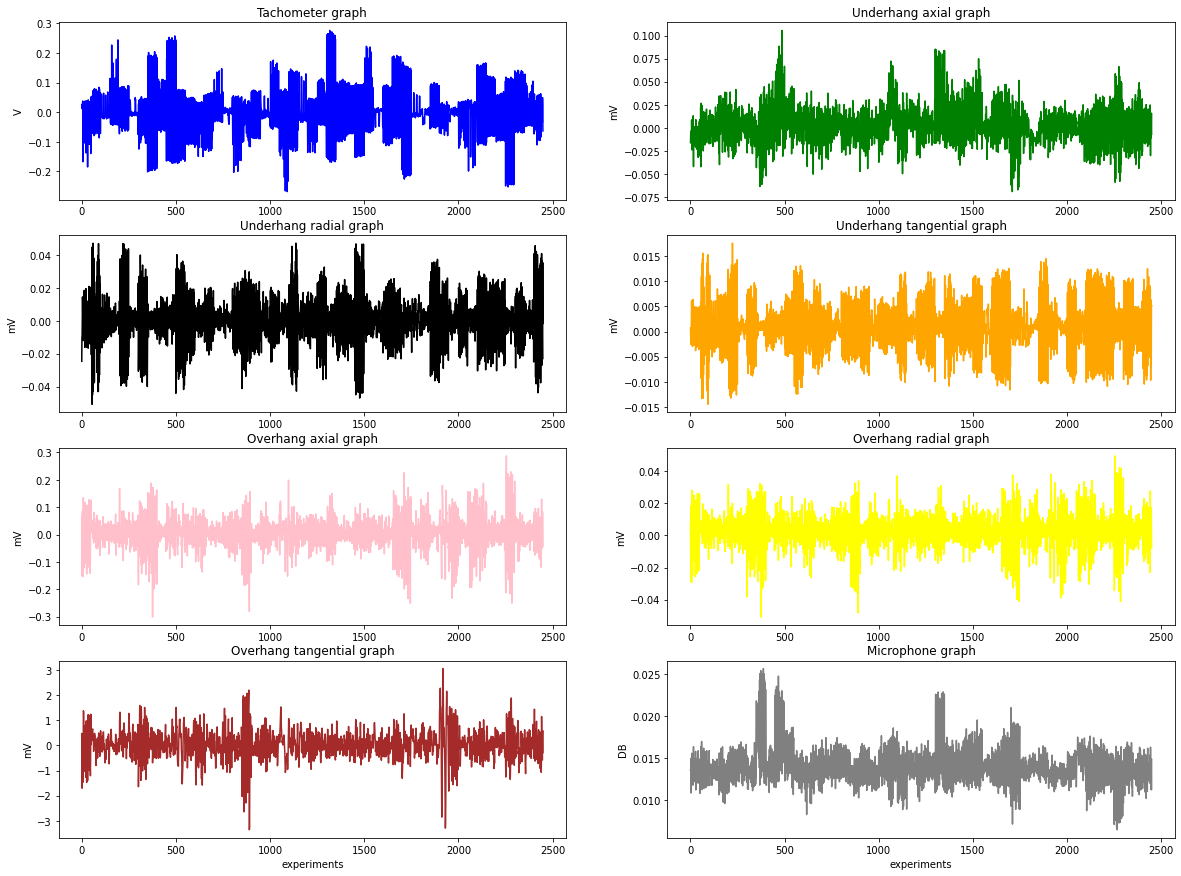

In [27]:
plot_all_features(imbalance_6_reduced)

## First Classification

Classify whether it is normal or unbalanced

In [28]:
y_normal = pd.DataFrame(np.ones(len(normal_reduced), dtype=int))
y_imbalance6 = pd.DataFrame(np.zeros(len(imbalance_6_reduced), dtype=int))
y_imbalance10 = pd.DataFrame(np.zeros(len(imbalance_10_reduced), dtype=int)) 
y_imbalance15 = pd.DataFrame(np.zeros(len(imbalance_15_reduced), dtype=int)) 
y_imbalance20 = pd.DataFrame(np.zeros(len(imbalance_20_reduced), dtype=int)) 
y_imbalance25 = pd.DataFrame(np.zeros(len(imbalance_25_reduced), dtype=int)) 
y_imbalance30 = pd.DataFrame(np.zeros(len(imbalance_30_reduced), dtype=int)) 
y_imbalance35 = pd.DataFrame(np.zeros(len(imbalance_35_reduced), dtype=int))

y = pd.concat([y_normal, y_imbalance6, y_imbalance10, y_imbalance15, y_imbalance20, y_imbalance25, y_imbalance30, y_imbalance35], ignore_index=True)
y

,0
0,1
1,1
2,1
3,1
4,1
...,...
19095,0
19096,0
19097,0
19098,0


In [29]:
data = pd.concat([normal_reduced, imbalance_6_reduced,imbalance_10_reduced, imbalance_15_reduced, imbalance_20_reduced, imbalance_25_reduced, imbalance_30_reduced, imbalance_35_reduced], ignore_index=True)
data

,Tachometer,UA axial,UA radial,UA tangential,OA axial,OA radial,OA tangential,Microphone
0,0.027298,0.007382,0.009080,0.001914,1.018441,0.011403,0.627217,0.012846
1,-0.048249,0.003625,-0.010702,0.001602,0.792528,0.000956,0.662295,0.012945
2,-0.127931,-0.016160,-0.003521,0.000138,-0.186234,-0.003084,0.074771,0.013773
3,0.023176,-0.036451,-0.009658,-0.001727,-0.992680,-0.007719,-0.594421,0.014016
4,0.015108,-0.018469,-0.000929,-0.002466,-0.051451,0.009010,-0.292022,0.013743
...,...,...,...,...,...,...,...,...
19095,-0.078605,-0.006836,-0.069864,0.009685,-0.362269,-0.000804,-0.186062,-0.000841
19096,-0.065429,0.027549,0.107036,0.019559,0.225668,0.006421,0.022360,-0.007102
19097,-0.068646,0.055616,0.066503,-0.009808,0.125643,0.003586,0.045547,-0.004729
19098,0.215295,0.022254,-0.095705,-0.018448,-0.055333,0.002122,0.009351,0.005904


In [30]:
#The data is desbalanced because just there is 2450 normal samples
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, shuffle=True)

In [31]:
print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)

Train shape:  (14325, 8)
Test shape:  (4775, 8)


In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(8, activation=tf.nn.softmax)])

2022-09-07 14:18:13.657870: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-07 14:18:14.472180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10792 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7
2022-09-07 14:18:14.473226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10792 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:06:00.0, compute capability: 3.7


In [33]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
448/448 [==============================] - 2s 3ms/step - loss: 0.6639 - accuracy: 0.8565
Epoch 2/5
448/448 [==============================] - 2s 4ms/step - loss: 0.3111 - accuracy: 0.8762
Epoch 3/5
448/448 [==============================] - 2s 3ms/step - loss: 0.2854 - accuracy: 0.8850
Epoch 4/5
448/448 [==============================] - 2s 3ms/step - loss: 0.2637 - accuracy: 0.8935
Epoch 5/5
448/448 [==============================] - 2s 3ms/step - loss: 0.2431 - accuracy: 0.9020


In [35]:
model.evaluate(X_test, y_test)

150/150 [==============================] - 1s 3ms/step - loss: 0.2370 - accuracy: 0.9097


[0.2370348870754242, 0.9097382426261902]

**Balancing data and training again!!**

In [44]:
imbalance_shape = len(normal_reduced) / 7

imbalance_6_reduced = imbalance_6_reduced[:int(imbalance_shape)]
imbalance_10_reduced = imbalance_10_reduced[:int(imbalance_shape)]
imbalance_15_reduced = imbalance_15_reduced[:int(imbalance_shape)]
imbalance_20_reduced = imbalance_20_reduced[:int(imbalance_shape)]
imbalance_25_reduced = imbalance_25_reduced[:int(imbalance_shape)]
imbalance_30_reduced = imbalance_30_reduced[:int(imbalance_shape)]
imbalance_35_reduced = imbalance_35_reduced[:int(imbalance_shape)]

In [45]:
y_normal = pd.DataFrame(np.ones(len(normal_reduced), dtype=int))
y_imbalance6 = pd.DataFrame(np.zeros(len(imbalance_6_reduced), dtype=int))
y_imbalance10 = pd.DataFrame(np.zeros(len(imbalance_10_reduced), dtype=int)) 
y_imbalance15 = pd.DataFrame(np.zeros(len(imbalance_15_reduced), dtype=int)) 
y_imbalance20 = pd.DataFrame(np.zeros(len(imbalance_20_reduced), dtype=int)) 
y_imbalance25 = pd.DataFrame(np.zeros(len(imbalance_25_reduced), dtype=int)) 
y_imbalance30 = pd.DataFrame(np.zeros(len(imbalance_30_reduced), dtype=int)) 
y_imbalance35 = pd.DataFrame(np.zeros(len(imbalance_35_reduced), dtype=int))

balanced_y = pd.concat([y_normal, y_imbalance6, y_imbalance10, y_imbalance15, y_imbalance20, y_imbalance25, y_imbalance30, y_imbalance35], ignore_index=True)
balanced_y

,0
0,1
1,1
2,1
3,1
4,1
...,...
4895,0
4896,0
4897,0
4898,0


In [46]:
balanced_data = pd.concat([normal_reduced, imbalance_6_reduced,imbalance_10_reduced, imbalance_15_reduced, imbalance_20_reduced, imbalance_25_reduced, imbalance_30_reduced, imbalance_35_reduced], ignore_index=True)
balanced_data

,Tachometer,UA axial,UA radial,UA tangential,OA axial,OA radial,OA tangential,Microphone
0,0.027298,0.007382,0.009080,0.001914,1.018441,0.011403,0.627217,0.012846
1,-0.048249,0.003625,-0.010702,0.001602,0.792528,0.000956,0.662295,0.012945
2,-0.127931,-0.016160,-0.003521,0.000138,-0.186234,-0.003084,0.074771,0.013773
3,0.023176,-0.036451,-0.009658,-0.001727,-0.992680,-0.007719,-0.594421,0.014016
4,0.015108,-0.018469,-0.000929,-0.002466,-0.051451,0.009010,-0.292022,0.013743
...,...,...,...,...,...,...,...,...
4895,0.067101,0.081382,0.149382,-0.003118,-0.011969,-0.000510,-0.249144,0.006739
4896,-0.082166,-0.068577,-0.127086,0.012441,0.018896,-0.000371,-0.073373,-0.068732
4897,0.023458,0.098143,0.099592,-0.020718,0.082801,0.019484,-0.027961,0.012872
4898,-0.052573,-0.066934,-0.056457,0.032554,0.029783,0.003629,0.231642,0.013406


In [47]:
X_train, X_test, y_train, y_test = train_test_split(balanced_data, balanced_y, test_size=0.25, shuffle=True)

In [48]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(8, activation=tf.nn.softmax)])

In [49]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
#The accuracy decreases because the model could assume 0 to hard inputs classification. Balanced data become classification harder
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
115/115 [==============================] - 1s 3ms/step - loss: 1.5065 - accuracy: 0.6204
Epoch 2/5
115/115 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.7578
Epoch 3/5
115/115 [==============================] - 0s 3ms/step - loss: 0.5528 - accuracy: 0.8000
Epoch 4/5
115/115 [==============================] - 0s 4ms/step - loss: 0.4897 - accuracy: 0.8103
Epoch 5/5
115/115 [==============================] - 0s 4ms/step - loss: 0.4531 - accuracy: 0.8207


In [51]:
model.evaluate(X_test, y_test)

39/39 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.8302


[0.4310043156147003, 0.8302040696144104]

**Applying FFT on balanced data**

In [52]:
normal_reduced = FFT(normal_reduced)
imbalance_6_reduced = FFT(imbalance_6_reduced)
imbalance_10_reduced = FFT(imbalance_10_reduced)
imbalance_15_reduced = FFT(imbalance_15_reduced)
imbalance_20_reduced = FFT(imbalance_20_reduced)
imbalance_25_reduced = FFT(imbalance_25_reduced)
imbalance_30_reduced = FFT(imbalance_30_reduced)
imbalance_35_reduced = FFT(imbalance_35_reduced)

In [53]:
print(normal_reduced.shape, imbalance_6_reduced.shape, imbalance_10_reduced.shape, imbalance_15_reduced.shape, imbalance_20_reduced.shape, imbalance_25_reduced.shape, imbalance_30_reduced.shape, imbalance_35_reduced.shape)

(4899, 15) (699, 15) (699, 15) (699, 15) (699, 15) (699, 15) (699, 15) (699, 15)


In [54]:
FFT_balanced_data = pd.concat([normal_reduced, imbalance_6_reduced,imbalance_10_reduced, imbalance_15_reduced, imbalance_20_reduced, imbalance_25_reduced, imbalance_30_reduced, imbalance_35_reduced], ignore_index=True)
FFT_balanced_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.000983,-0.000394,-0.000462,-0.000130,-0.031095,-0.002707,-0.011456,0.001349,0.211282,0.040030,0.606781,0.041804,0.294650,0.012991,0.000143
1,-0.000204,-0.000241,0.000018,-0.000055,-0.107068,0.003149,-0.101306,0.000850,0.291999,0.058014,0.247082,0.062128,0.098447,0.016532,0.000297
2,0.007892,0.000677,0.001447,-0.000123,-0.088640,0.001892,-0.112204,-0.008599,0.036063,0.013018,-1.011155,0.033442,-0.644437,0.008699,0.000456
3,0.008661,0.001586,0.000171,0.000126,0.032657,0.003640,0.079681,-0.007618,-0.501086,-0.085520,-2.134151,-0.049425,-1.320960,-0.010317,0.000597
4,-0.001524,0.002180,-0.000094,-0.000462,0.102618,-0.015845,0.171723,0.007179,-0.564611,-0.100138,-1.002434,-0.068172,-0.754281,-0.019373,0.000750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9787,0.010570,0.021539,0.053599,0.030374,0.000560,-0.012929,-0.042248,-0.035699,-0.078685,-0.026215,-0.056420,-0.012329,-0.019457,0.008356,0.001535
9788,-0.016849,-0.029194,-0.046724,-0.008916,0.010836,0.003862,-0.010530,-0.012756,0.061114,0.028709,-0.006010,0.006921,0.015101,0.085743,0.001876
9789,0.012936,0.032681,0.035607,-0.013271,-0.017815,-0.004932,-0.060727,-0.092439,-0.058115,0.019863,-0.042181,-0.012313,0.012947,0.004003,0.000608
9790,-0.014581,-0.023857,-0.009059,0.022586,0.027291,0.004232,0.054434,0.050209,-0.002777,-0.034969,-0.025845,-0.005193,-0.121685,-0.009551,0.000992


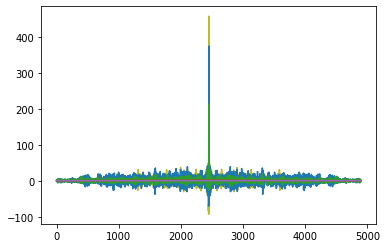

In [55]:
plt.plot(normal_reduced)
plt.show()

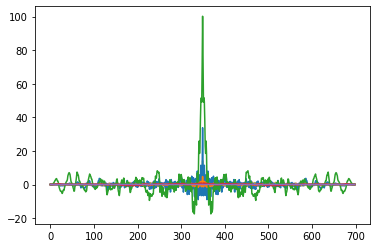

In [56]:
plt.plot(imbalance_35_reduced)
plt.show()

In [57]:
y_normal = pd.DataFrame(np.ones(len(normal_reduced), dtype=int))
y_imbalance6 = pd.DataFrame(np.zeros(len(imbalance_6_reduced), dtype=int))
y_imbalance10 = pd.DataFrame(np.zeros(len(imbalance_10_reduced), dtype=int)) 
y_imbalance15 = pd.DataFrame(np.zeros(len(imbalance_15_reduced), dtype=int)) 
y_imbalance20 = pd.DataFrame(np.zeros(len(imbalance_20_reduced), dtype=int)) 
y_imbalance25 = pd.DataFrame(np.zeros(len(imbalance_25_reduced), dtype=int)) 
y_imbalance30 = pd.DataFrame(np.zeros(len(imbalance_30_reduced), dtype=int)) 
y_imbalance35 = pd.DataFrame(np.zeros(len(imbalance_35_reduced), dtype=int))

FFT_balanced_y = pd.concat([y_normal, y_imbalance6, y_imbalance10, y_imbalance15, y_imbalance20, y_imbalance25, y_imbalance30, y_imbalance35], ignore_index=True)
FFT_balanced_y

,0
0,1
1,1
2,1
3,1
4,1
...,...
9787,0
9788,0
9789,0
9790,0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(FFT_balanced_data, FFT_balanced_y, test_size=0.25, shuffle=True)

In [67]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)])

In [68]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [69]:
#Apply FFT improved the results to this model
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
230/230 [==============================] - 1s 4ms/step - loss: 0.2222 - accuracy: 0.9266
Epoch 2/5
230/230 [==============================] - 1s 4ms/step - loss: 0.1280 - accuracy: 0.9551
Epoch 3/5
230/230 [==============================] - 1s 4ms/step - loss: 0.1056 - accuracy: 0.9631
Epoch 4/5
230/230 [==============================] - 1s 4ms/step - loss: 0.0900 - accuracy: 0.9669
Epoch 5/5
230/230 [==============================] - 1s 4ms/step - loss: 0.0755 - accuracy: 0.9722


In [70]:
model.evaluate(X_test, y_test)

77/77 [==============================] - 0s 3ms/step - loss: 0.0657 - accuracy: 0.9771


[0.06565306335687637, 0.9771241545677185]

#### REDE EXEMPLO

In [128]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train,y_train)
print("SVM accuracy is {} on Train Dataset".format(svm.score(X_train,y_train)))
print("SVM accuracy is {} on Test Dataset".format(svm.score(X_test,y_test)))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM accuracy is 0.9071553228621292 on Train Dataset
SVM accuracy is 0.9049214659685864 on Test Dataset


from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3) #n_neighbors = k
knn.fit(X_train,y_train)
print("k={}NN Accuracy on Train Data: {}".format(3,knn.score(X_train,y_train)))
print("k={}NN Accuracy on Test Data: {}".format(3,knn.score(X_test,y_test)))

## Fast Fourier Transform with Multiples Outputs

In [109]:
y_normal = pd.DataFrame(np.zeros(len(normal_reduced), dtype=int))
y_imbalance6 = pd.DataFrame(np.ones(len(imbalance_6_reduced), dtype=int))
y_imbalance10 = pd.DataFrame(np.full(len(imbalance_10_reduced), 2, dtype=int)) 
y_imbalance15 = pd.DataFrame(np.full(len(imbalance_15_reduced), 3, dtype=int)) 
y_imbalance20 = pd.DataFrame(np.full(len(imbalance_20_reduced), 4, dtype=int)) 
y_imbalance25 = pd.DataFrame(np.full(len(imbalance_25_reduced), 5, dtype=int)) 
y_imbalance30 = pd.DataFrame(np.full(len(imbalance_30_reduced), 6, dtype=int)) 
y_imbalance35 = pd.DataFrame(np.full(len(imbalance_35_reduced), 7, dtype=int))

y = pd.concat([y_normal, y_imbalance6, y_imbalance10, y_imbalance15, y_imbalance20, y_imbalance25, y_imbalance30, y_imbalance35], ignore_index=True)
y

,0
0,0
1,0
2,0
3,0
4,0
...,...
9787,7
9788,7
9789,7
9790,7


In [113]:
X_train, X_test, y_train, y_test = train_test_split(FFT_balanced_data, y, test_size=0.25, shuffle=True)

In [180]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.softmax)])

In [181]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [182]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
230/230 [==============================] - 1s 4ms/step - loss: 1.1399 - accuracy: 0.5779
Epoch 2/10
230/230 [==============================] - 1s 4ms/step - loss: 0.8980 - accuracy: 0.6634
Epoch 3/10
230/230 [==============================] - 1s 4ms/step - loss: 0.7868 - accuracy: 0.7030
Epoch 4/10
230/230 [==============================] - 1s 4ms/step - loss: 0.7170 - accuracy: 0.7330
Epoch 5/10
230/230 [==============================] - 1s 4ms/step - loss: 0.6405 - accuracy: 0.7659
Epoch 6/10
230/230 [==============================] - 1s 4ms/step - loss: 0.5942 - accuracy: 0.7746
Epoch 7/10
230/230 [==============================] - 1s 4ms/step - loss: 0.5452 - accuracy: 0.7955
Epoch 8/10
230/230 [==============================] - 1s 4ms/step - loss: 0.5093 - accuracy: 0.8088
Epoch 9/10
230/230 [==============================] - 1s 4ms/step - loss: 0.4637 - accuracy: 0.8224
Epoch 10/10
230/230 [==============================] - 1s 4ms/step - loss: 0.4348 - accuracy: 0.8329

In [187]:
model.evaluate(X_test, y_test)

77/77 [==============================] - 0s 3ms/step - loss: 0.4314 - accuracy: 0.8403


[0.4314194321632385, 0.8402777910232544]

In [184]:
def predict_multiple_out_model(x, y, index):
    responses = {0:'normal', 1:'imbalance_6g', 2:'imbalance_10g', 3:'imbalance_15g', 4:'imbalance_20g', 5:'imbalance_25g', 6:'imbalance_30', 7:'imbalance_35g'}
    predicts = model.predict(x)
    predict = responses[np.argmax(predicts[index], axis=0)]
    
    real_status = responses[int(y[0][index:index+1])]
    
    print("Status predicted: " + predict)
    print("Real Status: " + real_status)

In [186]:
predict_multiple_out_model(X_test, y_test, 32)

Status predicted: imbalance_6g
Real Status: imbalance_10g


In [190]:
model.save("my_model.h5")

In [193]:
model = load_model('my_model.h5')